In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
# 导入随机森林回归模型
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# 加载数据
# 假设 'housing.csv' 文件存在
df = pd.read_csv('housing.csv')

# 数据预处理
# 处理缺失值（如果有）
df = df.dropna()

# 处理分类变量 - 使用 One-Hot 编码
df = pd.get_dummies(df, columns=['ocean_proximity'], prefix='ocean')

# 分离特征和目标
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 创建并训练随机森林模型
# 使用 RandomForestRegressor 替代 DecisionTreeRegressor
rf_model = RandomForestRegressor(
    n_estimators=219,       # 森林中树的数量
    max_depth=30,           # 每棵树的最大深度
    min_samples_split=3,    # 分裂所需最小样本数
    min_samples_leaf=3,    # 叶子节点最小样本数
    random_state=42,
    n_jobs=-1               # 使用所有处理器核心进行并行计算
)
rf_model.fit(X_train, y_train)


# 交叉验证
cv_scores = cross_val_score(
    rf_model, X_train, y_train, 
    cv=5, 
    scoring='neg_mean_squared_error'
)

cv_rmse = np.sqrt(-cv_scores)
print(f"\n交叉验证 RMSE: {cv_rmse.mean():,.2f} (+/- {cv_rmse.std():,.2f})")

# 预测和评估
y_pred = rf_model.predict(X_test)

print("\n" + "=" * 50)
print("模型性能评估 (随机森林回归)")
print("=" * 50)
print(f'RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}')
print(f'MAE: ${mean_absolute_error(y_test, y_pred):,.2f}')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')


交叉验证 RMSE: 49,074.88 (+/- 1,763.74)

模型性能评估 (随机森林回归)
RMSE: $48,849.64
MAE: $31,671.07
R² Score: 0.8255


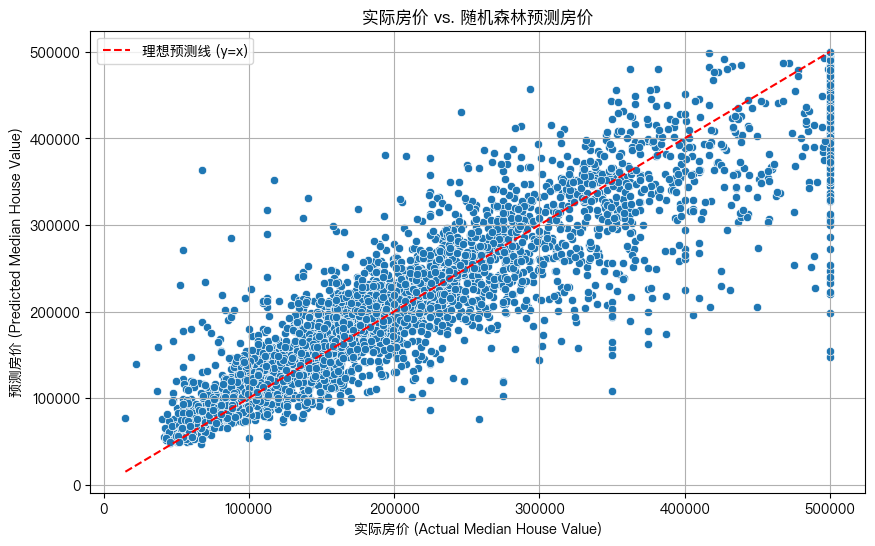

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn import tree
matplotlib.rcParams['font.sans-serif'] = "PingFang HK"


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)

# 添加 y=x 参考线
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='理想预测线 (y=x)')

plt.title('实际房价 vs. 随机森林预测房价')
plt.xlabel('实际房价 (Actual Median House Value)')
plt.ylabel('预测房价 (Predicted Median House Value)')
plt.legend()
plt.grid(True)
plt.show()

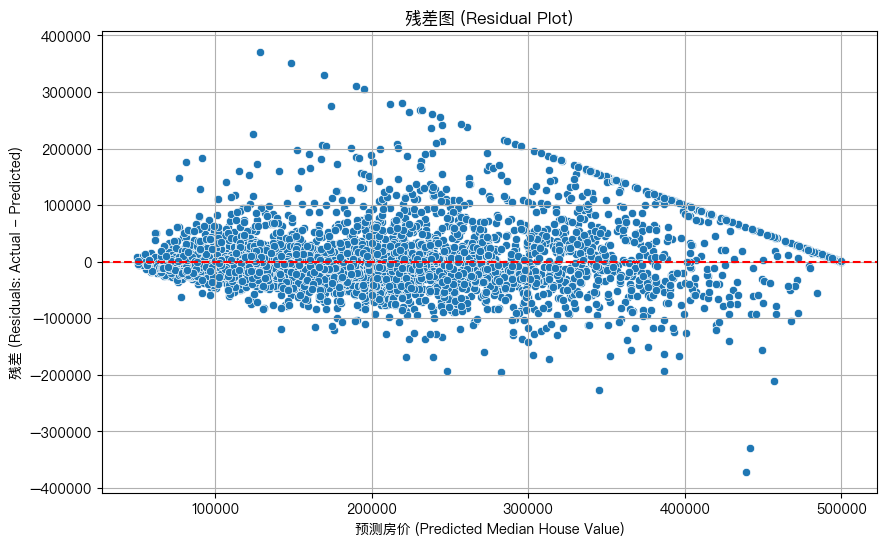

In [5]:
# 计算残差
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
# 绘制残差 vs 预测值
sns.scatterplot(x=y_pred, y=residuals) 

# 添加零线
plt.axhline(y=0, color='r', linestyle='--')

plt.title('残差图 (Residual Plot)')
plt.xlabel('预测房价 (Predicted Median House Value)')
plt.ylabel('残差 (Residuals: Actual - Predicted)')
plt.grid(True)
plt.show()

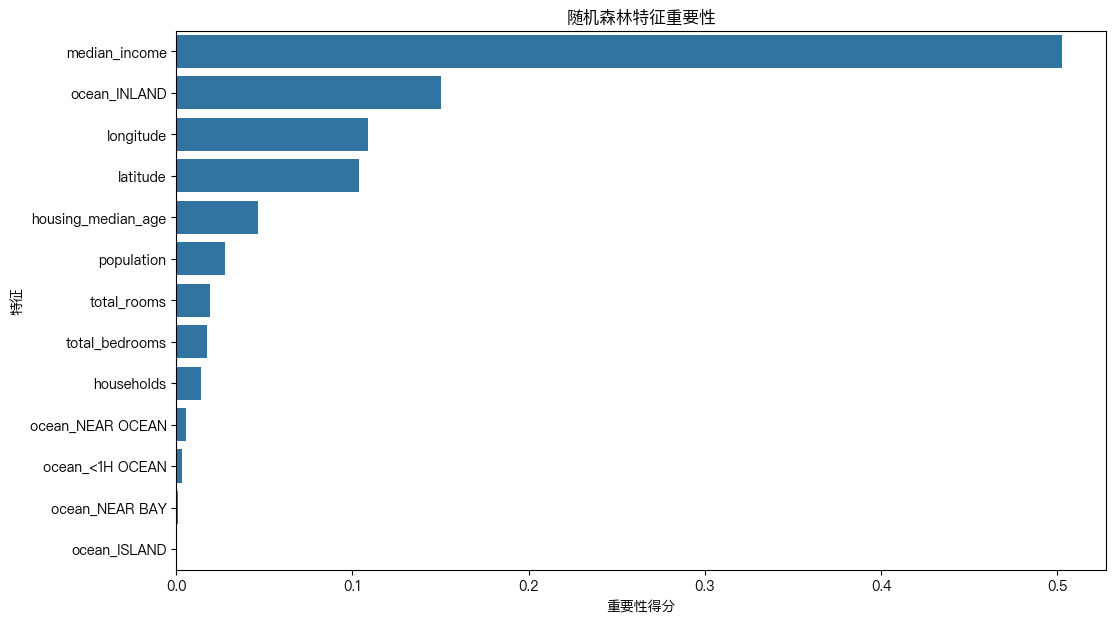

In [15]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
# 排序
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=feature_importances.values, y=feature_importances.index)

plt.title('随机森林特征重要性')
plt.xlabel('重要性得分')
plt.ylabel('特征')
plt.show()

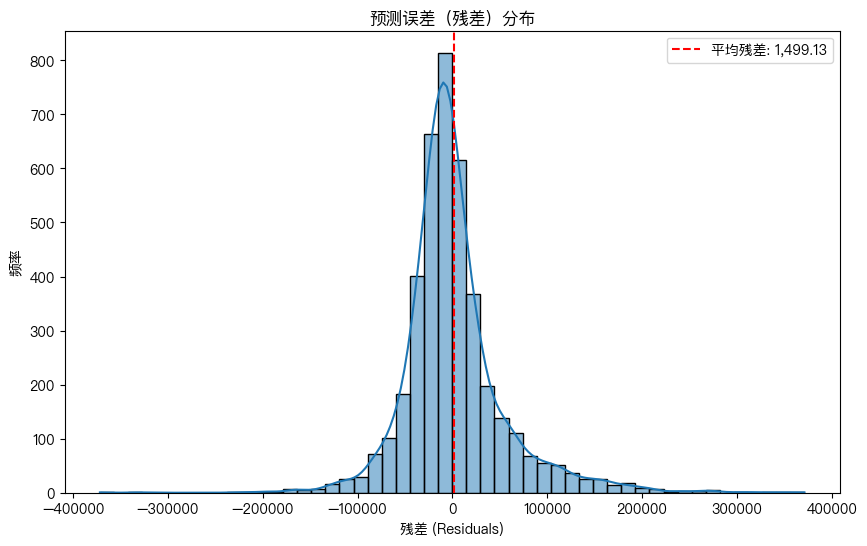

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)

# 添加平均残差线（理想情况下接近 0）
plt.axvline(residuals.mean(), color='r', linestyle='--', label=f'平均残差: {residuals.mean():,.2f}')

plt.title('预测误差（残差）分布')
plt.xlabel('残差 (Residuals)')
plt.ylabel('频率')
plt.legend()
plt.show()

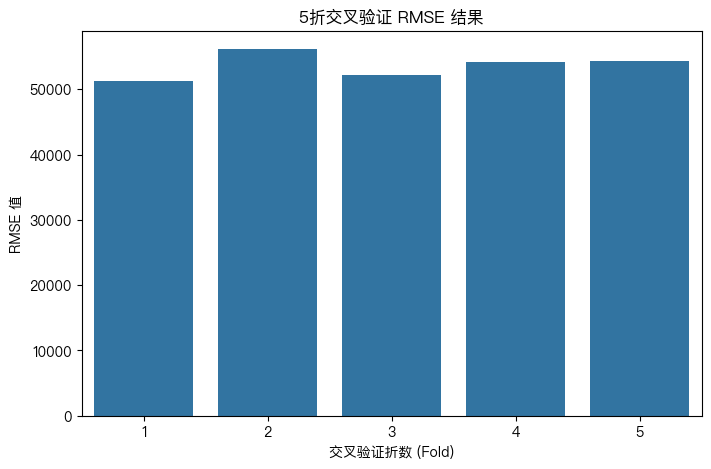

In [9]:

plt.figure(figsize=(8, 5))
sns.barplot(x=list(range(1, len(cv_rmse) + 1)), y=cv_rmse)

plt.title('5折交叉验证 RMSE 结果')
plt.xlabel('交叉验证折数 (Fold)')
plt.ylabel('RMSE 值')
plt.show()

# 超参数调优

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 定义参数的分布（而不是固定的列表）
param_dist = {
    'n_estimators': randint(low=50, high=300),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(low=2, high=20),
    'min_samples_leaf': randint(low=1, high=10)
}

# 创建 RandomizedSearchCV 对象
# n_iter=50 表示只测试 50 种随机组合
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50, # 随机采样的次数
    cv=5, 
    scoring='neg_mean_squared_error', 
    random_state=42, 
    verbose=2, 
    n_jobs=-1
)

# 执行搜索
print("开始执行 RandomizedSearchCV...")
random_search.fit(X_train, y_train)

# 查看最佳结果
print(f"\n最佳超参数组合 (随机搜索): {random_search.best_params_}")

开始执行 RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

最佳超参数组合 (随机搜索): {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 219}


In [10]:
from sklearn.model_selection import GridSearchCV

# 定义要搜索的超参数网格
param_grid = {
    'n_estimators': [50, 100, 200],  # 树的数量
    'max_depth': [10, 20, None],     # 树的最大深度 (None 表示不限制)
    'min_samples_split': [2, 5, 10], # 分裂所需最小样本数
    'min_samples_leaf': [1, 5, 10]   # 叶子节点最小样本数
}


# 创建基础模型
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# 创建 GridSearchCV 对象
# cv=5 表示使用 5 折交叉验证
# scoring='neg_mean_squared_error' 用于评估，目标是最大化这个负值（即最小化 MSE）
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=2, # 打印详细进度信息
    n_jobs=-1  # 使用所有核心并行计算
)


# 执行网格搜索
print("开始执行 GridSearchCV...")
grid_search.fit(X_train, y_train)


# 最佳参数组合
print(f"\n最佳超参数组合: {grid_search.best_params_}")

# 最佳交叉验证分数 (负均方误差)
best_neg_mse = grid_search.best_score_
best_rmse = np.sqrt(-best_neg_mse)
print(f"最佳交叉验证 RMSE: {best_rmse:,.2f}")

# 获取最佳模型
best_rf_model = grid_search.best_estimator_

开始执行 GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

最佳超参数组合: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
最佳交叉验证 RMSE: 49,173.41


In [11]:
# 使用最佳模型进行预测
y_pred_tuned = best_rf_model.predict(X_test)

# 评估调优后的模型
print("\n" + "=" * 50)
print("调优后的模型性能评估 (随机森林回归)")
print("=" * 50)
print(f'RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_tuned)):,.2f}')
print(f'MAE: ${mean_absolute_error(y_test, y_pred_tuned):,.2f}')
print(f'R² Score: {r2_score(y_test, y_pred_tuned):.4f}')


调优后的模型性能评估 (随机森林回归)
RMSE: $48,710.55
MAE: $31,629.24
R² Score: 0.8265


开始执行 RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

最佳超参数组合 (随机搜索): {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 219}
